<a href="https://colab.research.google.com/github/yupopov/stepik-dl-cv/blob/main/module03_wine_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wine quality prediction with fully connected networks

In this notebook we try to achieve the best classification accuracy on the classical [wine quality](https://archive.ics.uci.edu/ml/datasets/wine+quality) dataset by varying the neural network's hyperparameters.

In [ ]:
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data, 
    wine.target, 
    test_size=0.3, 
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [ ]:
class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(X_train.shape[1], n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x
    
wine_net = WineNet(5)
wine_net = wine_net.to(device)

optimizer = torch.optim.Adam(wine_net.parameters(), 
                             lr=1.0e-3)

In [ ]:
loss = torch.nn.CrossEntropyLoss()

Let us fiddle with the model parameters.

In [ ]:
def train_net(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, n_hidden_neurons=15, batch_size=124, n_epochs=5000):

  wine_net = WineNet(n_hidden_neurons).to(device)
  optimizer = torch.optim.Adam(wine_net.parameters(),
                               lr=1.0e-3)
  scores = []

  for epoch in range(n_epochs):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = wine_net.forward(x_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    if epoch % 100 == 0:
      test_preds = wine_net.forward(X_test)
      test_preds = test_preds.argmax(dim=1)
      score = (test_preds == y_test).float().mean().to('cpu')
      scores.append(score)
    
  return scores 

## 1. Changing the number of hidden neurons

Let us plot the quality of the model with respect to the `n_hidden_neurons` parameter:

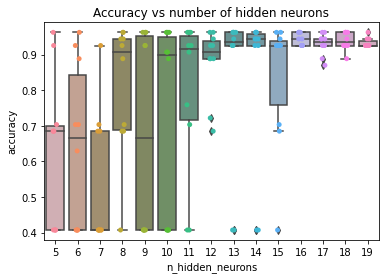

In [ ]:
scores = []
neurons_range = np.arange(5, 20)
for n_hidden_neurons in neurons_range:
    scores.append([])
    for _ in range(10):
      net_score = train_net(n_hidden_neurons=n_hidden_neurons)[-1]
      scores[-1].append(net_score.numpy())

scores = pd.DataFrame(np.array(scores).T, columns=neurons_range)

sns.stripplot(data=scores)
sns.boxplot(data=scores, saturation=0.3)
plt.title('Accuracy vs number of hidden neurons')
plt.xlabel('n_hidden_neurons')
plt.ylabel('accuracy');

We see that starting with `n_hidden_neurons` = 16 our neural network learns stably well, and there is not much difference in prediction qualities for various instances of the network.

For lower values of `n_hidden_neurons`, however, the network failures to obtain good results or doesn't learn at all.

## 2. Varying the test size

Let's vary the test size and see at which proportion of the test set we get accuracy worse than the base rate accuracy (the share of the largest class), which is 0.3988:

In [ ]:
pd.Series(wine.target).value_counts(normalize=True)

1    0.398876
0    0.331461
2    0.269663
dtype: float64

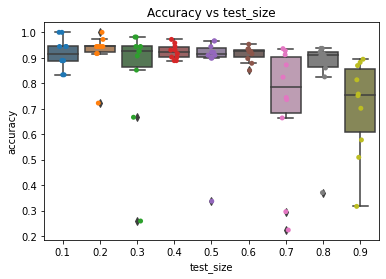

In [ ]:
test_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
scores = []
for test_size in test_sizes:
    scores.append([])
    for _ in range(10):
      X_train, X_test, y_train, y_test = train_test_split(
      wine.data, 
      wine.target, 
      test_size=test_size, 
      shuffle=True)

      X_train = torch.FloatTensor(X_train).to(device)
      X_test = torch.FloatTensor(X_test).to(device)
      y_train = torch.LongTensor(y_train).to(device)
      y_test = torch.LongTensor(y_test).to(device)

      net_score = train_net(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)[-1]
      scores[-1].append(net_score.numpy())

scores = pd.DataFrame(np.array(scores).T, columns=test_sizes)

sns.stripplot(data=scores)
sns.boxplot(data=scores, saturation=0.3)
plt.title('Accuracy vs test_size')
plt.xlabel('test_size')
plt.ylabel('accuracy');

We see that the accuracy decreases when the test size increases, but still not so much to be less than the base rate.

## 3. Varying the batch size

Let's change the batch size and measure the train times.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    wine.data, 
    wine.target,
    train_size=128, 
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [ ]:
from time import time
batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128]
scores = []
for batch_size in batch_sizes:
    scores.append([])
    for _ in range(10):
      time1 = time()
      _ = train_net(batch_size=batch_size, n_epochs=100)
      time2 = time()
      scores[-1].append(time2 - time1)

scores = pd.DataFrame(np.array(scores).T, columns=batch_sizes)

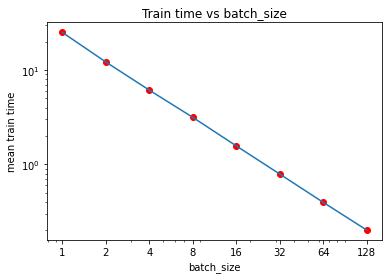

In [ ]:
plt.title('Train time vs batch_size')
plt.xlabel('batch_size')
plt.ylabel('mean train time');
plt.xscale('log')
plt.yscale('log')
plt.xticks(ticks=batch_sizes, labels=batch_sizes)
plt.plot(batch_sizes, scores.mean(axis=0));
plt.scatter(batch_sizes, scores.mean(axis=0), c='r');
# plt.fill_between(batch_sizes, scores.mean(axis=0) - scores.std(axis=0), scores.mean(axis=0) + scores.std(axis=0)) no use, stds are too small

As expected, we see that the train time depends linearly on the batch size (twice the batch size implies half the train time).

## 4. Varying the number of epochs

Let's fix the network architecture and see which number of epochs we should do.

In [ ]:
scores = []
for _ in range(10):
  scores.append(train_net(n_hidden_neurons=16, n_epochs=5000))
scores = np.array(scores)

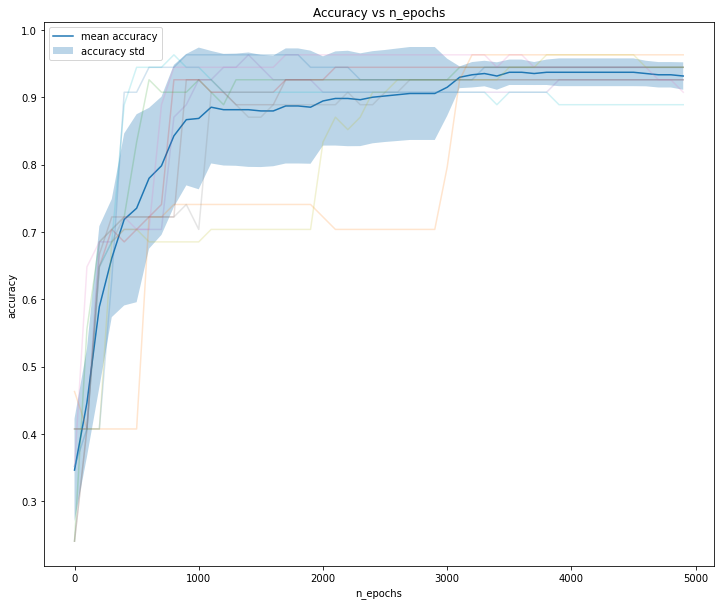

In [ ]:
plt.figure(figsize=(12, 10))
epochs_range = np.linspace(0, 4900, 50)
plt.title('Accuracy vs n_epochs')
plt.xlabel('n_epochs')
plt.ylabel('accuracy')
plt.plot(epochs_range, scores.mean(axis=0), label='mean accuracy');
for i in range(10):
  plt.plot(epochs_range, scores[i], alpha=0.2)
plt.fill_between(epochs_range, scores.mean(axis=0) - scores.std(axis=0),
                 scores.mean(axis=0) + scores.std(axis=0), alpha=0.3, label='accuracy std')
plt.legend(loc='best');

We see that the worse run achieves its maximum accuracy around epoch number 3000. We can use this number as the number of epochs or, assuming that the number of the epoch with the highest accuracy is normally distributed, obtain the following upper estimate:

In [ ]:
argmax_epochs = scores.argmax(axis=1) * 100
argmax_epochs.mean() + 3 * argmax_epochs.std()

5157.999354422141

## Conclusion

We saw clearly that the quality of the predictions depends on the model structure. However, it depends on the quality of the input data as well, so in order to improve the predictive capability one has to analyze the data (particularly, it's well-known that this dataset contains many linearly dependent features, and one can benefit from transforming/removing them).